# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [9]:
# Restart the Kernel after you execute this command.
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,)),
                               transforms.Lambda(lambda x: x.view(-1))])

# Create training set and define training dataloader
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download = True)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=32,
                                          shuffle=True)

# Dataloader for visualization
vis = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download = True)

vis_loader = torch.utils.data.DataLoader(vis,
                                          batch_size=32,
                                          shuffle=True)
# Create test set and define test dataloader
test_dataset = datasets.MNIST(root = 'data/', train = False, transform = transform, download = True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=True)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


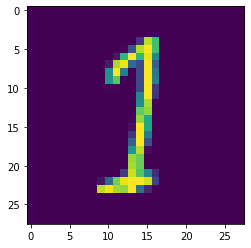

7


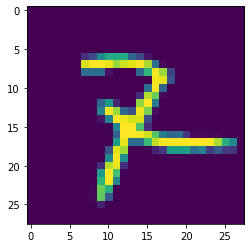

4


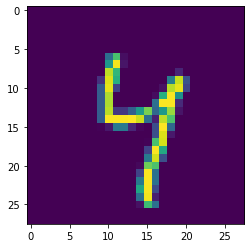

1


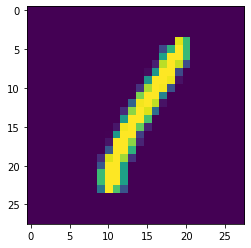

0


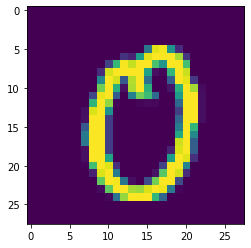

In [4]:
# Explore data
show5(vis_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),                # Flatten [1, 28, 28] to [784]
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)           # 10 output classes for MNIST
        )
        
    def forward(self, x):
        return self.model(x)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
model = MNISTNet()

# CrossEntropyLoss combines LogSoftmax and NLLLoss, suitable for multi-class classification
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
from torch.utils.data import random_split, DataLoader

# Define the sizes
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [18]:
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

Epoch 1/5 | Train Loss: 0.0667 | Val Loss: 0.1039 | Val Acc: 97.46%
Epoch 2/5 | Train Loss: 0.0677 | Val Loss: 0.0919 | Val Acc: 97.67%
Epoch 3/5 | Train Loss: 0.0595 | Val Loss: 0.0986 | Val Acc: 97.71%
Epoch 4/5 | Train Loss: 0.0587 | Val Loss: 0.0915 | Val Acc: 97.74%
Epoch 5/5 | Train Loss: 0.0572 | Val Loss: 0.0913 | Val Acc: 97.75%


Plot the training loss (and validation loss/accuracy, if recorded).

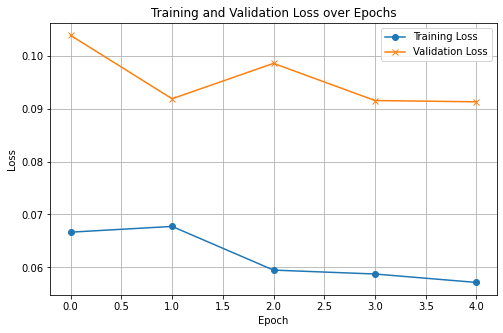

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [20]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0902
Test Accuracy: 97.86%


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.99      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



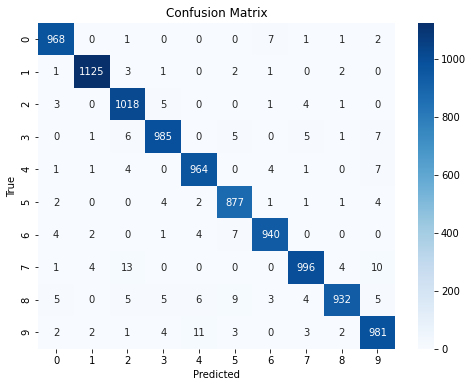

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print(classification_report(all_labels, all_preds))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [16]:
class MNISTNET(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # output: (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # output: (32, 14, 14)

            nn.Conv2d(32, 64, 3, padding=1), # output: (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # output: (64, 7, 7)

            nn.Flatten(),                    # output: 64*7*7
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

## Saving your model
Using `torch.save`, save your model for future loading.

In [17]:
torch.save(model.state_dict(), 'mnist_model.pth')